# Finding Spatial Clusters of COVID-19 increases with ESCIP

Short intro: We are looking for spatial clusters of high/low COVID-19 increases with respect to the underlying population, i.e., we are looking for places with drastic or abnormally slight increases in COVID-19 cases unproportional to the underlying population. 

## Data Preparation

In [25]:
# Plotting the population data
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

import numpy as np
import pandas as pd
import geopandas as gpd

import folium

In [2]:
from escip_poisson import Model

COVID-19 Data
The data is retrieved from Johns Hopkins CSSE COVID-19 cases dataset repository.

The data format is CSV file.

In [3]:
counties = gpd.read_file("data/counties_shp_correct_for_nyc/counties.shp")
counties['FIPS'] = (counties['STATE_FIPS'].astype('str') + counties['CNTY_FIPS'].astype('str')).astype('int')
counties = counties.set_index('FIPS')

In [4]:
# confirmed_cases = pd.read_csv(
#     "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
# )
confirmed_cases = pd.read_csv('https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')
# confirmed_cases = confirmed_cases[confirmed_cases['Province_State'] == 'New York']
confirmed_cases = confirmed_cases[confirmed_cases['Country_Region'] == 'US']
confirmed_cases = confirmed_cases[confirmed_cases['Province_State'] != 'Alaska']
confirmed_cases = confirmed_cases[confirmed_cases['Province_State'] != 'Hawaii']
confirmed_cases = confirmed_cases[confirmed_cases['Province_State'] != 'Puerto Rico']
confirmed_cases = confirmed_cases[confirmed_cases['UID'] != 84046102] # South Dokata...
confirmed_cases = confirmed_cases[confirmed_cases['Admin2'].isnull() == False]
confirmed_cases = confirmed_cases[confirmed_cases['FIPS'] < 80000]
confirmed_cases['FIPS'] = confirmed_cases['FIPS'].astype('int')
confirmed_cases = confirmed_cases.set_index('FIPS')

Computing the daily increase in COVID-19 death.

In [5]:
dates = confirmed_cases.columns[11:]
for i in range(1, len(dates)):
    confirmed_cases[dates[i]] = confirmed_cases[dates[i]] - confirmed_cases[dates[i-1]]

In [6]:
confirmed_cases.drop(dates[0], axis=1, inplace = True)

In [7]:
cases = confirmed_cases.merge(counties, left_index=True, right_index=True)

In [8]:
cases['POP2012'] = cases['POP2012'].astype('int')

In [9]:
columns = ['Long_','Lat', 'POP2012', 'NAME', 'STATE_NAME', 'STATE_FIPS', 'CNTY_FIPS']
columns.extend(dates[1:])
cases_ = gpd.GeoDataFrame(cases[columns], geometry = gpd.points_from_xy(cases.Long_, cases.Lat))

In [10]:
cases_

,Long_,Lat,POP2012,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,1/23/20,1/24/20,1/25/20,...,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,geometry
FIPS,,,,,,,,,,,,,,,,,,,,,
1001,-86.644082,32.539527,55939,Autauga,Alabama,01,001,0,0,0,...,2,2,2,2,2,2,2,2,2,POINT (-86.64408 32.53953)
1003,-87.722071,30.727750,190116,Baldwin,Alabama,01,003,0,0,0,...,3,4,3,5,3,5,3,5,3,POINT (-87.72207 30.72775)
1005,-85.387129,31.868263,27310,Barbour,Alabama,01,005,0,0,0,...,1,0,1,0,1,0,1,0,1,POINT (-85.38713 31.86826)
1007,-87.125115,32.996421,23106,Bibb,Alabama,01,007,0,0,0,...,0,1,0,1,0,1,0,1,0,POINT (-87.12511 32.99642)
1009,-86.567906,33.982109,58107,Blount,Alabama,01,009,0,0,0,...,0,0,0,0,0,0,1,0,1,POINT (-86.56791 33.98211)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,-108.882788,41.659439,45509,Sweetwater,Wyoming,56,037,0,0,0,...,0,0,0,0,0,0,0,0,0,POINT (-108.88279 41.65944)
56039,-110.589080,43.935225,22666,Teton,Wyoming,56,039,0,0,0,...,0,0,0,0,0,0,0,0,0,POINT (-110.58908 43.93522)
56041,-110.547578,41.287818,21533,Uinta,Wyoming,56,041,0,0,0,...,0,0,0,0,0,0,0,0,0,POINT (-110.54758 41.28782)


In [11]:
cases_.crs= 'EPSG:4326'
cases_ = cases_.to_crs('+proj=utm +zone=15 +ellps=GRS80 +units=m +no_defs')

In [12]:
len(cases[cases_[dates[-1]] < 0])

20

In [13]:
cases_['x'] = cases_.apply(lambda x: x['geometry'].coords[0][0], axis=1)
cases_['y'] = cases_.apply(lambda x: x['geometry'].coords[0][1], axis=1)

In [14]:
cases_.drop('geometry', axis = 1, inplace = True)

In [17]:
type(cases_)

geopandas.geodataframe.GeoDataFrame

In [18]:
cases_.geometry = cases.geometry
cases_.geometry = cases_.geometry.simplify(0.01)
cases_.crs= 'EPSG:4326'

# ESCIP for COVID-19

In this model, we are modeling the expected COVID-19 increases in a heterogenous poisson process with varying the mean determined by underlying population density. 

Hotspots could be interpreted as places with higher increases that are unproportional to the population. 

map = folium.Map(location=[48, -102], zoom_start=3)

cases_render = cases[cases.cluster_id > -1]
gjs = folium.Choropleth(cases_render, columns=['FIPS', 'likelihood_cluster'], nan_fill_opacity=0, fill_color='YlOrRd').add_to(map)

map

In [27]:
!rm -r tmp_death
!mkdir tmp_death
from tqdm import tqdm

In [28]:
columns = ['POP2012', 'NAME', 'STATE_NAME', 'STATE_FIPS', 'CNTY_FIPS']
for date in tqdm(dates[-30:]):
    m = Model(cases_, background=None, epsilon=50000.0, cases_name=date, background_name = 'POP2012')
    date_ = date.split('/')
    date_ = "{:02d}-{:02d}-{:02d}".format(int(date_[2]), int(date_[0]), int(date_[1]))
    for tail in ['left', 'right']:
        m.register_model(tail=tail)
        m.expansion()
        m.extract_clusters(minimum_len=1, n_mcs=100)
        cluster_info = m.dump_clusters('tmp_death/' + date_ + '_' + tail, lim=80, merge=True)
        cases_o = cases_[columns + [date, 'geometry']].copy()
        cases_o['cluster_id'] = np.nan
        cases_o['likelihood_cluster'] = np.nan
        cases_o['p_value'] = np.nan
        for i in range(len(cluster_info)):
            cases_o['cluster_id'].iloc[cluster_info.points.iloc[i]] = i
            cases_o['likelihood_cluster'].iloc[cluster_info.points.iloc[i]] = cluster_info.lw.iloc[i]
            cases_o['p_value'].iloc[cluster_info.points.iloc[i]] = cluster_info.p.iloc[i]
        cases_o.to_file('tmp_death/' + date_ + '_' + tail + '.geojson', driver='GeoJSON')

100%|██████████| 30/30 [21:12<00:00, 42.40s/it]


In [21]:
clusters_result = gpd.read_file('tmp_death/clusters.geojson')

In [22]:
clusters_result.head()

,FIPS,Long_,Lat,POP2012,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,1/23/20,1/24/20,...,20-05-17_cluster_id,20-05-17_likelihood_cluster,20-05-17_p_value,20-05-18_cluster_id,20-05-18_likelihood_cluster,20-05-18_p_value,20-05-19_cluster_id,20-05-19_likelihood_cluster,20-05-19_p_value,geometry
0,1001,-86.644082,32.539527,55939,Autauga,Alabama,01,001,0,0,...,-1,NaN,NaN,-1,NaN,NaN,-1,NaN,NaN,"MULTIPOLYGON (((-86.41130 32.42699, -86.41138 ..."
1,1003,-87.722071,30.727750,190116,Baldwin,Alabama,01,003,0,0,...,-1,NaN,NaN,-1,NaN,NaN,-1,NaN,NaN,"MULTIPOLYGON (((-87.55692 30.28155, -87.55693 ..."
2,1005,-85.387129,31.868263,27310,Barbour,Alabama,01,005,0,0,...,-1,NaN,NaN,-1,NaN,NaN,-1,NaN,NaN,"POLYGON ((-85.25782 32.14797, -85.25835 32.146..."
3,1007,-87.125115,32.996421,23106,Bibb,Alabama,01,007,0,0,...,-1,NaN,NaN,-1,NaN,NaN,-1,NaN,NaN,"POLYGON ((-87.02587 33.22258, -87.02585 33.220..."
4,1009,-86.567906,33.982109,58107,Blount,Alabama,01,009,0,0,...,19,32338.846972,0.0,-1,NaN,NaN,18,33407.42943,0.0,"MULTIPOLYGON (((-86.83831 33.95018, -86.83833 ..."


/Users/weiye/opt/anaconda3/envs/GIS37/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/weiye/opt/anaconda3/envs/GIS37/lib/python3.7/site-packages/contextily/tile.py:629: UserWarning: The inferred zoom level of 22 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


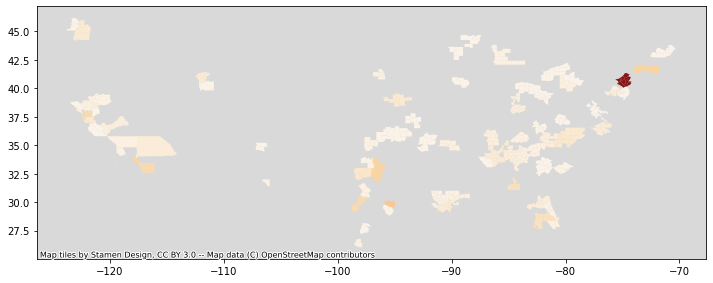

In [36]:
ax = clusters_result.plot(column = '20-05-19_likelihood_cluster', cmap='OrRd', figsize=(12, 6),
                    linewidth = 0.5, alpha = 0.9)
ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)